In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=100
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('csv_files/used cars dataset.csv')
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [3]:
df.sample()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
664731,Toyota,RAV4 LE,2019,29089.0,2.5L I4 16V PDI DOHC,8-Speed Automatic,Front-wheel Drive,Gasoline,26-35,Magnetic Gray Metallic,Black,0.0,1.0,1.0,Rock Honda,3.7,4.5,450.0,2357.0,28638.0


In [4]:
(df.isna().mean()*100).round(2) # nan percentage

manufacturer            0.00
model                   0.00
year                    0.00
mileage                 0.07
engine                  1.97
transmission            1.30
drivetrain              2.83
fuel_type               3.01
mpg                    18.64
exterior_color          1.16
interior_color          7.48
accidents_or_damage     3.18
one_owner               4.13
personal_use_only       3.26
seller_name             1.13
seller_rating          28.08
driver_rating           4.15
driver_reviews_num      0.00
price_drop             46.19
price                   0.00
dtype: float64

In [5]:
df.select_dtypes('O').nunique()

manufacturer         30
model             12187
engine             6903
transmission       1313
drivetrain           33
fuel_type            36
mpg                 865
exterior_color     7681
interior_color     4679
seller_name       18254
dtype: int64

# DATA CLEANING AND PREPROCESSING 

##### mileage 

In [6]:
df['mileage']=df.groupby('year')['mileage'].transform(lambda x:x.fillna(x.median()))

# data imputation for mileage

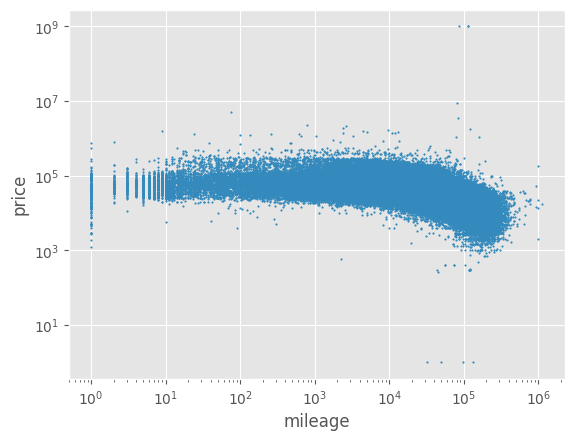

In [7]:
df.plot.scatter(x='mileage',y='price',s=1)
plt.xscale('log')
plt.yscale('log')

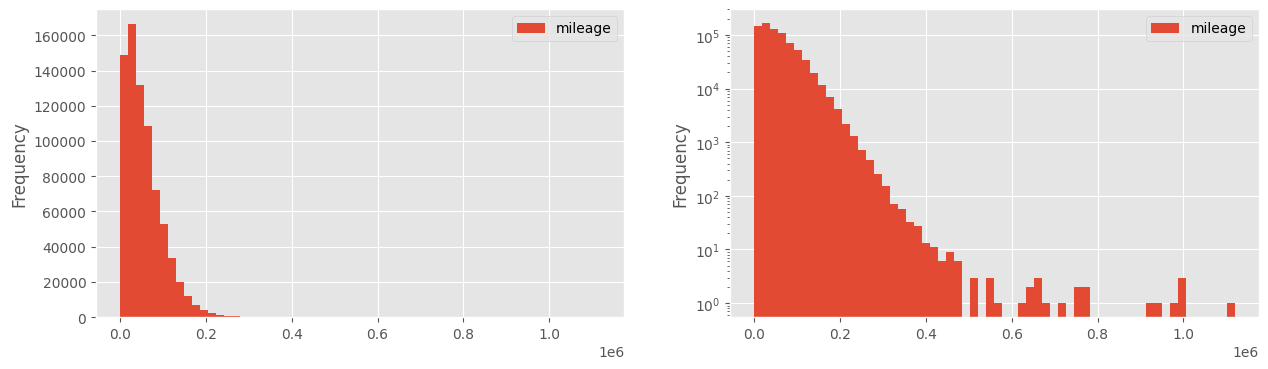

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4))
df.plot.hist(ax=ax1,y='mileage',bins=60)
df.plot.hist(ax=ax2,y='mileage',bins=60)
ax2.set_yscale('log')
plt.show()

In [9]:
df[df['mileage']>10**6]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
757916,Volvo,XC70 3.2L,2010,1119067.0,Gas I6 3.2L/195,Automatic,All-wheel Drive,Gasoline,16-22,Black,Beige,0.0,0.0,1.0,Walser Toyota,3.1,4.3,17.0,NaN,16997.0


In [10]:
df['mileage'].value_counts().sort_values(ascending=False).head(20)

0.0        1564
10.0        272
1.0         260
5.0         230
6.0         179
1000.0      151
11.0        149
12.0        146
2260.0      145
8.0         139
7.0         138
10000.0     129
15.0        128
9.0         123
3.0         111
3000.0      101
31000.0      93
88000.0      90
90000.0      85
25000.0      85
Name: mileage, dtype: int64

##### mpg

In [11]:
min_mpg=df['mpg'].apply(lambda x:x.split('-')[0].strip() if str(x)!='nan' else x).astype(float)
max_mpg=df['mpg'].apply(lambda x:x.split('-')[-1].strip() if str(x)!='nan' else x).astype(float)

avg_mpg=(min_mpg+max_mpg)/2
df['mpg']=avg_mpg

##### price 

In [12]:
df=df.query('1000<price<0.2*10**6')

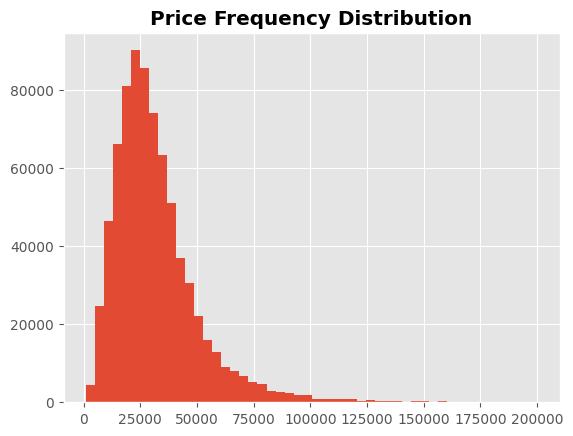

In [13]:
df['price'].hist(bins=50)
plt.title('Price Frequency Distribution',fontweight='bold')
plt.show()

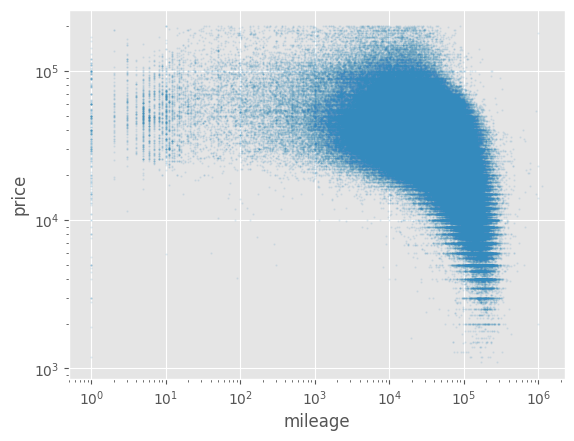

In [30]:
df.plot.scatter(x='mileage',y='price',s=1,alpha=0.1)
plt.xscale('log')
plt.yscale('log')

In [15]:
drop_cols=['model','engine','transmission','exterior_color','interior_color','seller_name']
df=df.drop(columns=drop_cols)

In [16]:
df.select_dtypes('O').nunique()

manufacturer    30
drivetrain      33
fuel_type       36
dtype: int64

In [17]:
for col in df.select_dtypes('O'):
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

# BUILDING ML MODEL  

In [18]:
X=df.drop(columns='price')
y=df['price']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [19]:
from xgboost import XGBRegressor
model=XGBRegressor()

from sklearn import metrics

In [20]:
%%time

model.fit(X_train,y_train)

CPU times: total: 12min 36s
Wall time: 5min 22s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [22]:
r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.median_absolute_error(train_prediction,y_train)
mae_test=metrics.median_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.8684119029176081 0.8588953787128081
2466.4716796875 2487.2392578125
6590.233384519691 6848.92357208643


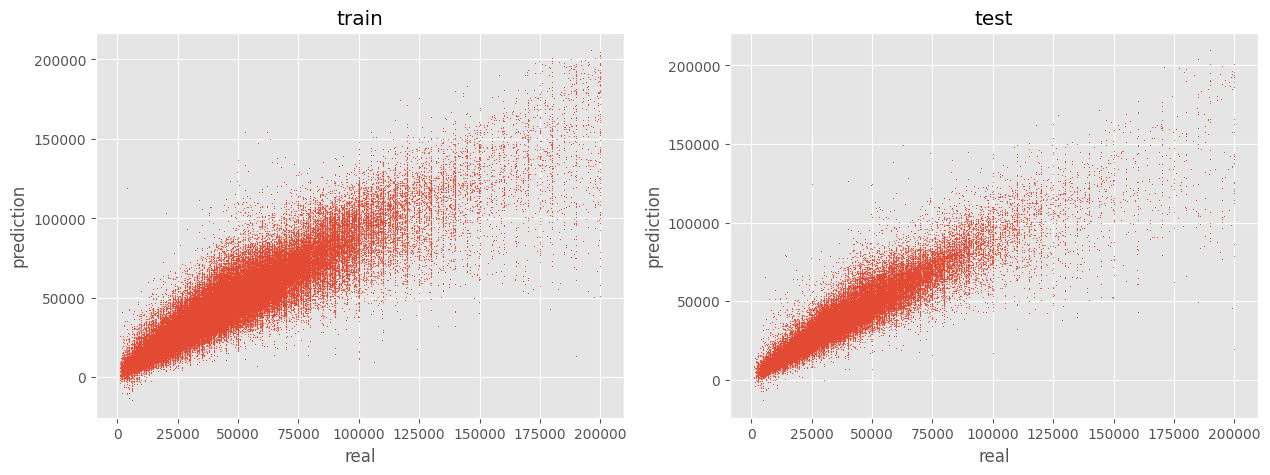

In [23]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction,s=0.1)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')
ax2.scatter(y_test,test_prediction,s=0.1)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

# ERROR ANALYSIS 

In [24]:
test=X_test
test['Real']=y_test
test['Prediction']=test_prediction
test['Error']=(test['Real']-test['Prediction']).abs()

In [25]:
cols=['year','mileage','mpg','seller_rating','driver_rating','Real','Prediction','Error']
test=test[cols]

In [26]:
test

,year,mileage,mpg,seller_rating,driver_rating,Real,Prediction,Error
697167,2019,41720.0,20.0,4.1,4.6,39048.0,37450.281250,1597.718750
620691,1996,85400.0,14.0,NaN,4.4,65000.0,32328.716797,32671.283203
489534,2020,6227.0,22.5,4.3,4.8,43995.0,45834.457031,1839.457031
314054,2020,35179.0,23.5,4.8,4.8,32509.0,33851.511719,1342.511719
322790,2020,27714.0,26.0,2.6,4.9,35865.0,34309.042969,1555.957031
...,...,...,...,...,...,...,...,...
301759,2013,64285.0,21.0,4.7,4.3,17177.0,16375.337891,801.662109
357240,2020,42562.0,24.5,4.9,4.7,26109.0,27301.421875,1192.421875
423905,2017,54061.0,21.0,4.7,4.7,17000.0,20534.480469,3534.480469
243249,2020,39573.0,27.5,4.5,4.7,18999.0,21878.972656,2879.972656


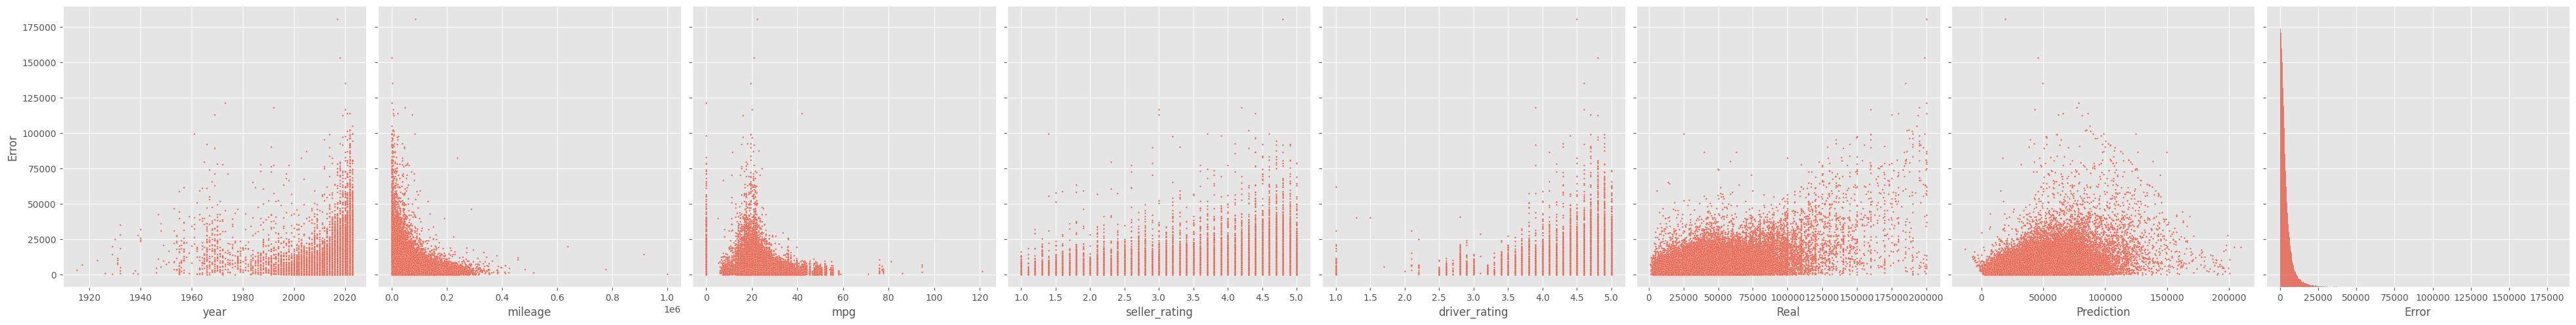

CPU times: total: 9.98 s
Wall time: 12.5 s


In [27]:
%%time

sns.pairplot(test,height=5,y_vars='Error',x_vars=test.select_dtypes(['int','float']).columns,plot_kws={"s": 3})
plt.show()

In [31]:
# the model struggles with prediction, when the car age is low...

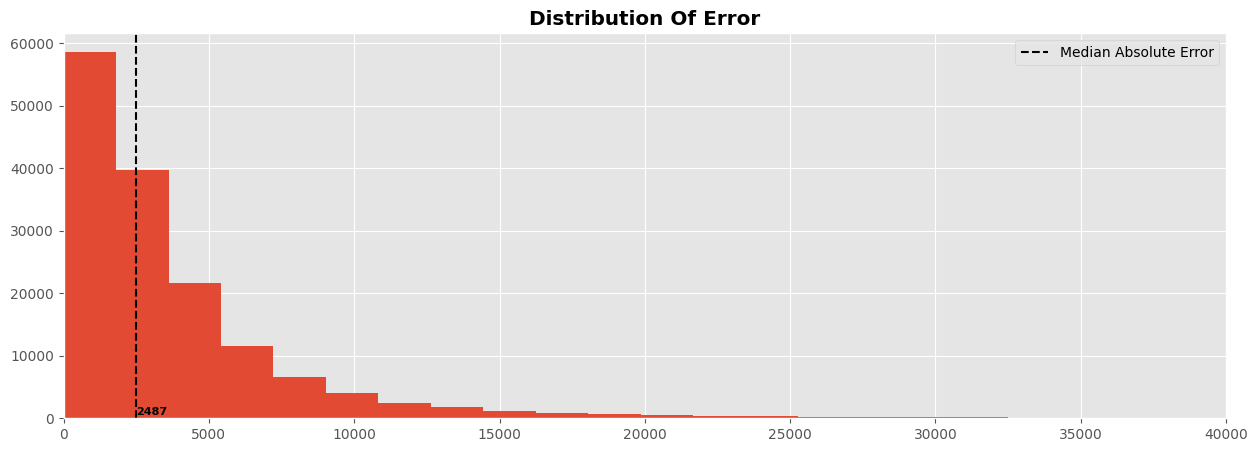

In [29]:
mean=test['Error'].mean()
median=test['Error'].median()

test['Error'].hist(bins=100,figsize=(15,5))
plt.title('Distribution Of Error',fontweight='bold')
plt.axvline(median,label='Median Absolute Error',color='black',ls='--')
plt.text(median,500,int(median),fontweight='bold',size=8)
plt.xlim(0,40000)
plt.legend()
plt.show()